In [1]:
import pandas as pd
from sklearn import datasets
from sklearn import linear_model
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

from sklearn.metrics import log_loss, make_scorer, accuracy_score
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
import pickle
from pathlib import Path


In [10]:
prediction_path = Path("./prediction.csv")

submission_format = pd.read_csv("../data/partial_submission_format.csv")
test_data = pd.read_csv("./testing_data.csv")
airports = test_data["airport"].unique().tolist()

In [12]:
air="kdfw"
airport_test_data = test_data.copy()
airport_test_data = airport_test_data[airport_test_data["airport"] == air]

possible_labels = pd.read_csv(f"{air}_possibel_config")["0"].values.tolist()

feature_cols = ["temperature", "wind_speed", "wind_gust", "cloud_ceiling", "visibility", \
              "cloud", "lightning_prob", "precip","wind_direction_cos", "wind_direction_sin", "depart1", "deaprt2", "depart3", "depart4", \
                    "arrive1", "arrive2", "arrive3", "arrive4", "lookahead"]
for i in range(len(possible_labels)):
    feature_cols.append('cur_config_hot'+str(i))

X = airport_test_data.loc[:, feature_cols]

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-10)
imp = imp.fit(X)
X = imp.transform(X)

model_file = open(f"{air}_trained_model_LR.pkl", "rb")
model = pickle.load(model_file)
model_file.close()

predicted_probabilities = model.predict_proba(X).tolist()
to_add = np.setdiff1d(np.array(range(len(possible_labels))),model.classes_)
cur_classes = model.classes_
for i in range(len(predicted_probabilities)):
    for j in to_add:
        predicted_probabilities[i].insert(j, 1e-5)
    x_p_other = predicted_probabilities[i][len(predicted_probabilities[i])-1]
    if x_p_other<.6:
        predicted_probabilities[i][len(predicted_probabilities[i])-1] = pow(x_p_other,.7)


predicted_probabilities = normalize(np.array(predicted_probabilities), axis=1, norm="l1")

# Check this code!
submission_format.loc[submission_format["airport"] == air, "active"] = predicted_probabilities.flatten()

In [13]:
submission_format.loc[submission_format["airport"] == air]["active"]

797040     0.002629
797041     0.007707
797042     0.000576
797043     0.000104
797044     0.000046
             ...   
1098355    0.000006
1098356    0.000089
1098357    0.000017
1098358    0.000008
1098359    0.195112
Name: active, Length: 301320, dtype: float64

In [17]:
submission_format.loc[submission_format["active"] == predicted_probabilities[i][len(predicted_probabilities[i])-1]]

,airport,timestamp,lookahead,config,active
1098359,kdfw,2021-06-20T23:00:00,360,kdfw:other,0.195112


In [21]:
submission_format.loc[submission_format["active"] == predicted_probabilities[i][len(predicted_probabilities[i])-1]]["timestamp"]

NameError: name 'submission_format' is not defined

In [25]:
#submission_format=submission_format[submission_format["airport"] == air]
#air_labeled_submission=labeled_submission[labeled_submission["airport"] == air]
test_date = pd.read_csv("../data/partial_submission_format.csv", parse_dates=["timestamp"])

In [29]:
test_date.loc[0,"timestamp"].month == 1

True

In [30]:
merged_data = submission_format.merge(air_labeled_submission, on=["airport", "timestamp", "lookahead", "config"], how="inner", sort=False)

In [11]:
test_data[test_data["airport"]==air].actual_label

267408    3.0
267409    3.0
267410    3.0
267411    3.0
267412    3.0
         ... 
356539    4.0
356540    4.0
356541    4.0
356542    4.0
356543    4.0
Name: actual_label, Length: 89136, dtype: float64

In [10]:
score = log_loss(predicted_probabilities.flatten(), test_data[test_data["airport"]==air].actual_label)
score

ValueError: Found input variables with inconsistent numbers of samples: [89136, 2763216]

In [48]:
for air in airports:
    air_labeled_submission=labeled_submission[labeled_submission["airport"] == air]

0.08061409901437551

In [8]:
active_labeled_submission = labeled_submission[labeled_submission["active"]==1]

In [9]:
active_labeled_submission

,airport,timestamp,lookahead,config,active
19,katl,2020-11-06T23:00:00,30,katl:D_8R_9L_A_10_8L_9R,1.0
46,katl,2020-11-06T23:00:00,60,katl:D_8R_9L_A_10_8L_9R,1.0
73,katl,2020-11-06T23:00:00,90,katl:D_8R_9L_A_10_8L_9R,1.0
100,katl,2020-11-06T23:00:00,120,katl:D_8R_9L_A_10_8L_9R,1.0
127,katl,2020-11-06T23:00:00,150,katl:D_8R_9L_A_10_8L_9R,1.0
...,...,...,...,...,...
25200809,ksea,2021-10-17T10:00:00,240,ksea:D_16L_A_16L_16R,1.0
25200821,ksea,2021-10-17T10:00:00,270,ksea:D_16L_A_16L_16R,1.0
25200833,ksea,2021-10-17T10:00:00,300,ksea:D_16L_A_16L_16R,1.0
25200845,ksea,2021-10-17T10:00:00,330,ksea:D_16L_A_16L_16R,1.0


In [18]:
labeled_submission = pd.read_csv("../data/prescreened_train_labels.csv.bz2")

for air in airports:
    possible_labels = pd.read_csv(f"{air}_possibel_config")["0"].values.tolist()
    train_port = active_labeled_submission[active_labeled_submission["airport"] == air]
    print(air)
    print(np.setdiff1d(possible_labels, train_port["config"].unique().tolist()))
    # print(train_port.groupby(["config"])["config"].count())

katl
['katl:D_9L_A_9R']
kclt
[]
kden
[]
kdfw
[]
kjfk
[]
kmem
[]
kmia
[]
kord
[]
kphx
[]
ksea
[]


In [6]:
airports = active_labeled_submission["airport"].unique().tolist()

In [20]:
test_data

,Unnamed: 0,airport,temperature,wind_speed,wind_gust,cloud_ceiling,visibility,cloud,lightning_prob,precip,...,cur_config_hot33,cur_config_hot34,cur_config_hot35,cur_config_hot36,cur_config_hot37,cur_config_hot38,cur_config_hot39,cur_config_hot40,cur_config_hot41,lookahead
0,0,katl,37.0,6.0,0.0,8.0,7.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
1,0,katl,37.0,5.0,0.0,8.0,7.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
2,1,katl,36.0,6.0,0.0,8.0,7.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
3,2,katl,36.0,6.0,0.0,8.0,7.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0
4,3,katl,36.0,6.0,0.0,8.0,7.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97195,2194,ksea,77.0,7.0,0.0,8.0,7.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,240.0
97196,2195,ksea,77.0,7.0,0.0,8.0,7.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0
97197,2196,ksea,73.0,6.0,0.0,8.0,7.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0
97198,2197,ksea,73.0,6.0,0.0,8.0,7.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0


In [7]:
from sklearn.model_selection import train_test_split
train = pd.read_csv("../LR_training/training_data.csv")
for air in airports:
    train_port = active_labeled_submission[active_labeled_submission["airport"] == air]
    possible_labels = pd.read_csv(f"{air}_possibel_config")["0"].values.tolist()
    for i in range(len(possible_labels)):
        print(air+" "+str(i)+" "+ str(train_port[f"cur_config_hot{i}"].sum()))

KeyError: 'cur_config_hot0'

In [44]:
for air in airports:
    possible_labels = pd.read_csv(f"{air}_possibel_config")["0"].values.tolist()
    training = train[train["airport"] == air]
    feature_cols = ["temperature", "wind_speed", "wind_gust", "cloud_ceiling", "visibility", \
                  "cloud", "lightning_prob", "precip","wind_direction_cos", "wind_direction_sin", "depart1", "deaprt2", "depart3", "depart4", \
                        "arrive1", "arrive2", "arrive3", "arrive4", "lookahead"]
    for i in range(len(possible_labels)):
        feature_cols.append('cur_config_hot'+str(i))
    X = training.loc[:, feature_cols]
    y = training.actual_label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
    # Some weather data is missing :(
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp = imp.fit(x_train)
    x_train = imp.transform(x_train)
    imp = imp.fit(x_test)
    x_test = imp.transform(x_test)
    
    model_file = open(f"{air}_trained_model_LR.pkl", "rb")
    model = pickle.load(model_file)
    model_file.close()

    predicted_probabilities = model.predict_proba(x_train).tolist()
    to_add = np.setdiff1d(np.array(range(len(possible_labels))),model.classes_)
    cur_classes = model.classes_
    for i in range(len(predicted_probabilities)):
      for j in to_add:
         predicted_probabilities[i].insert(j, 1e-8)
    y_test_onehot = []
    for i in y_train:
      temp = [0]*(len(possible_labels))

      temp[int(i)] = 1
      y_test_onehot.append(temp)

    predicted_probabilities = normalize(np.array(predicted_probabilities), axis=1, norm="l1")

    score = log_loss(np.array(y_test_onehot).flatten(), predicted_probabilities.flatten())
    print(score)

0.04296507701512244
0.09219869492546853
0.06310407581258409
0.052471324805039306
0.07923278234265223
0.06950669598632767
0.050058218411956144
0.05993888886715423
0.06638646885339407
0.060888577617882744


In [30]:
np.array(y_test_onehot).shape

(2675, 27)

In [31]:
predicted_probabilities.shape

(2675, 31)

In [33]:
len(possible_labels)

'katl'

In [19]:
config = pd.read_csv("../data/katl/katl_airport_config.csv.bz2")

In [22]:
config[config["airport_config"]=="D_9L_A_9R"]

,timestamp,airport_config
12347,2021-10-28T03:53:00,D_9L_A_9R


In [3]:
import matplotlib.pyplot as plt


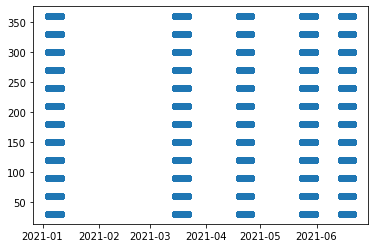

In [10]:
test_date = pd.read_csv("../data/partial_submission_format.csv", parse_dates=["timestamp"])

plt.plot_date(test_date["timestamp"], test_date["lookahead"])

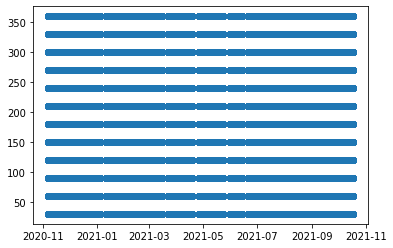

In [11]:
training_dates = pd.read_csv("../data/open_train_labels.csv.bz2", parse_dates=["timestamp"], compression = "bz2")
plt.plot_date(training_dates["timestamp"], training_dates["lookahead"])

AttributeError: 'GradientBoostingClassifier' object has no attribute 'tree_'

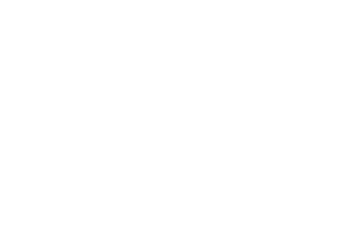

In [6]:
from sklearn.tree import plot_tree
for air in airports:
    model_file = open(f"{air}_trained_model.pkl", "rb")
    model = pickle.load(model_file)
    model_file.close()
    plot_tree(model)
    plt.show()


In [2]:
import pickle

In [4]:
model_file = open(f"./katl_trained_model_temporal3_p.pkl", "rb")
model = pickle.load(model_file)
model_file.close()

In [8]:
model.coef_

array([[ 2.77603413e-03,  2.89952443e-01,  1.12227081e-01,
        -2.73377044e-01, -2.50722130e-01, -9.59358085e-02,
        -4.15759665e-02,  7.45582571e-02,  3.52314807e-01,
         1.41482495e-01, -6.08312558e-02, -2.19282581e-02,
        -2.91687146e-02, -2.62880755e-02, -2.19318706e-02,
        -3.18238694e-02, -2.55016720e-02, -2.12948426e-01,
        -3.31431174e-02, -2.92608432e-02, -2.10629820e-02,
        -5.99308289e-02, -1.27091136e-02, -2.53320455e-02,
        -2.20911255e-02, -4.12262399e-02, -1.54126524e-02,
         2.93913674e-01, -2.37104988e-02, -2.28532832e-02,
        -3.00688168e-02, -2.70871190e-02, -3.48391851e-02,
         0.00000000e+00, -3.77789959e-02],
       [-3.12594716e-02,  1.92117684e-01, -1.28162306e-01,
         2.49546659e-01,  3.29955333e-01, -5.42367277e-03,
        -7.13723319e-02,  7.61301398e-03, -1.28609673e-02,
         4.02356492e-01,  2.62046546e-01, -1.41952741e-02,
         1.49184882e-01, -1.60977272e-02, -9.04719134e-03,
        -1.84

In [9]:
model.intercept_

array([-0.81572848, -0.87777461, -0.46663337, -0.04762105,  0.11976299,
        0.1825445 , -0.88534203, -0.23050585,  0.39012261,  4.20944761,
       -0.0894808 , -0.67959695, -0.28208076,  0.10806713, -0.84218837,
       -0.97947175, -0.18845995, -0.6102195 , -1.23123595,  3.44375487,
       -0.64075828, -0.83711984, -0.24163703, -0.73643094, -0.11309047,
        2.34167628])